In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [7]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = 3*x*x

In [14]:
tape.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=18.0>

In [15]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [16]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)

In [20]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

In [22]:
tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [24]:
(x_train,y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255., x_test/255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [25]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [26]:
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
x_train.shape,y_train.shape, x_test.shape, y_test.shape

(TensorShape([60000, 28, 28, 1]),
 (60000,),
 TensorShape([10000, 28, 28, 1]),
 (10000,))

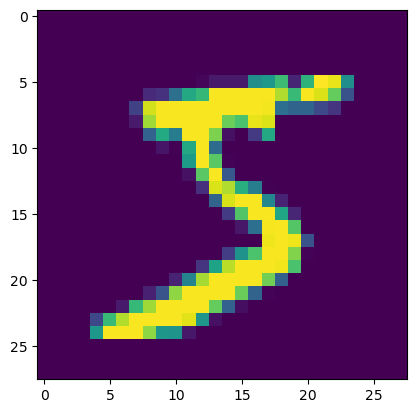

In [29]:
plt.imshow(x_train[0])

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(32, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32, drop_remainder=False).prefetch(buffer_size=AUTOTUNE)

In [31]:
class CustomCNN(keras.layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.conv = keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')
        self.bn = keras.layers.BatchNormalization()
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x
    def model(self):
        x = keras.Input()
        return keras.Model(inputs=[x], outputs=self.call(x))

In [32]:
cus_model = keras.Sequential([
    keras.Input(shape=(28,28, 1)),
    CustomCNN(32),
    CustomCNN(64),
    CustomCNN(128),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

In [33]:
cus_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_cnn (CustomCNN)      (None, 28, 28, 32)        448       
                                                                 
 custom_cnn_1 (CustomCNN)    (None, 28, 28, 64)        18752     
                                                                 
 custom_cnn_2 (CustomCNN)    (None, 28, 28, 128)       74368     
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 10)                1003530   
                                                                 
Total params: 1,097,098
Trainable params: 1,096,650
Non-trainable params: 448
_________________________________________________________________


In [41]:
class Custom_fit(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def compile(self, optimizer, loss, metric):
        super(Custom_fit, self).compile()
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
    
    def train_step(self, data):
        #unpack the data
        x, y = data
        with tf.GradientTape() as tape:
            #computing predication
            y_pred = self.model(x, training=True)
            #Calculating loss
            loss = self.loss(y, y_pred)
            
        #Tracking gradients
        training_vars = self.trainable_variables
        print('training_vars:', training_vars)
        gradients = tape.gradient(loss, training_vars)
        
        #Update optimizer and metrics
        self.optimizer.apply_gradients(zip(gradients, training_vars))
        self.metric.update_state(y, y_pred)
        
        return {'Train loss for custom train':loss, 'Train accuracy for custom train':self.metric.result()}
    
    def test_step(self, data):
        #Unpack the data
        x, y = data
        #compute prediction
        y_pred = self.model(x, training=False)
        #calculate loss
        loss = self.loss(y, y_pred)
        #update optimizer and metrics
        self.metric.update_state(y, y_pred)
        
        return {'The loss for custom test':loss, 'Test accuracy for custom test':self.metric.result()}

In [42]:
cust_train = Custom_fit(cus_model)

In [43]:
cust_train.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metric=keras.metrics.SparseCategoricalAccuracy(name='accuracy')
                  )

In [44]:
cust_train.fit(train_dataset, batch_size=32, epochs=2)

Epoch 1/2
training_vars: [<tf.Variable 'custom_cnn/conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32>, <tf.Variable 'custom_cnn/conv2d/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'custom_cnn/batch_normalization/gamma:0' shape=(32,) dtype=float32>, <tf.Variable 'custom_cnn/batch_normalization/beta:0' shape=(32,) dtype=float32>, <tf.Variable 'custom_cnn_1/conv2d_1/kernel:0' shape=(3, 3, 32, 64) dtype=float32>, <tf.Variable 'custom_cnn_1/conv2d_1/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'custom_cnn_1/batch_normalization_1/gamma:0' shape=(64,) dtype=float32>, <tf.Variable 'custom_cnn_1/batch_normalization_1/beta:0' shape=(64,) dtype=float32>, <tf.Variable 'custom_cnn_2/conv2d_2/kernel:0' shape=(3, 3, 64, 128) dtype=float32>, <tf.Variable 'custom_cnn_2/conv2d_2/bias:0' shape=(128,) dtype=float32>, <tf.Variable 'custom_cnn_2/batch_normalization_2/gamma:0' shape=(128,) dtype=float32>, <tf.Variable 'custom_cnn_2/batch_normalization_2/beta:0' shape=(128,) dtype=float32>, <tf.Varia